In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv3D, BatchNormalization, Dropout, concatenate, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# --- Load and preprocess data ---
df = pd.read_csv('smart_traffic_management_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

# Time-based features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Encode categorical
for col in ['weather_condition', 'signal_status']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Lag and rolling mean features
df['traffic_volume_lag_1'] = df['traffic_volume'].shift(1)
df['traffic_volume_lag_3'] = df['traffic_volume'].shift(3)
df['traffic_volume_lag_6'] = df['traffic_volume'].shift(6)
df['traffic_volume_rollmean_6'] = df['traffic_volume'].rolling(window=6).mean()
df.dropna(inplace=True)

# Feature and target columns
features = ['location_id', 'avg_vehicle_speed', 'vehicle_count_cars', 'vehicle_count_trucks',
            'vehicle_count_bikes', 'weather_condition', 'temperature', 'humidity',
            'accident_reported', 'signal_status', 'hour', 'dayofweek', 'month',
            'traffic_volume_lag_1', 'traffic_volume_lag_3', 'traffic_volume_lag_6',
            'traffic_volume_rollmean_6']
target = 'traffic_volume'

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

In [3]:
# --- Sequence creation ---
SEQ_LEN = 30
FORECAST_HORIZON = 30

def create_sequences(X, y, seq_len=30, forecast_horizon=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len - forecast_horizon):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len + forecast_horizon - 1])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN, FORECAST_HORIZON)

# Reshape for ConvLSTM2D input
X_seq = X_seq.reshape((X_seq.shape[0], SEQ_LEN, X_seq.shape[2], 1, 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [4]:
inputs = Input(shape=(SEQ_LEN, X_seq.shape[2], 1, 1))

e1 = ConvLSTM2D(32, (3, 1), padding='same', return_sequences=True, activation='relu')(inputs)
e1 = BatchNormalization()(e1)

e2 = ConvLSTM2D(64, (3, 1), padding='same', return_sequences=True, activation='relu')(e1)
e2 = BatchNormalization()(e2)

bottleneck = ConvLSTM2D(128, (3, 1), padding='same', return_sequences=True, activation='relu')(e2)
bottleneck = BatchNormalization()(bottleneck)
bottleneck = Dropout(0.3)(bottleneck)

d1 = ConvLSTM2D(64, (3, 1), padding='same', return_sequences=True, activation='relu')(bottleneck)
d1 = BatchNormalization()(d1)
d1 = concatenate([d1, e2])

d2 = ConvLSTM2D(32, (3, 1), padding='same', return_sequences=True, activation='relu')(d1)
d2 = BatchNormalization()(d2)
d2 = concatenate([d2, e1])

output_3d = Conv3D(1, (1, 1, 1), activation='linear')(d2)
x_flat = Flatten()(output_3d)
x_dense = Dense(64, activation='relu')(x_flat)
x_dense = Dropout(0.2)(x_dense)
final_output = Dense(1, activation='linear')(x_dense)

model = Model(inputs, final_output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [5]:
# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 397ms/step - loss: 0.8016 - mae: 0.6896 - val_loss: 0.3068 - val_mae: 0.4732 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - loss: 0.3502 - mae: 0.4359 - val_loss: 0.2367 - val_mae: 0.4043 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 398ms/step - loss: 0.1469 - mae: 0.3047 - val_loss: 0.2028 - val_mae: 0.3715 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - loss: 0.1591 - mae: 0.3187 - val_loss: 0.1629 - val_mae: 0.3331 - learning_rate: 0.0010
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 436ms/step - loss: 0.1324 - mae: 0.2967 - val_loss: 0.1636 - val_mae: 0.3337 - learning_rate: 0.0010
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 398ms/step - loss: 0.0996 - mae: 0.2649 - val_loss: 0.1293 - val_mae: 0.3003 - learning_rate: 0.0010
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 394ms/step - loss: 0.1041 - mae: 0.2709 - val_loss: 0.1441 - val_mae: 0.3147 - learning_rate:

In [6]:
# --- Evaluate ---
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"\n📊 UNet-ConvLSTM MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 753ms/step

📊 UNet-ConvLSTM MAE: 238.43, MSE: 76278.30, R²: 0.008


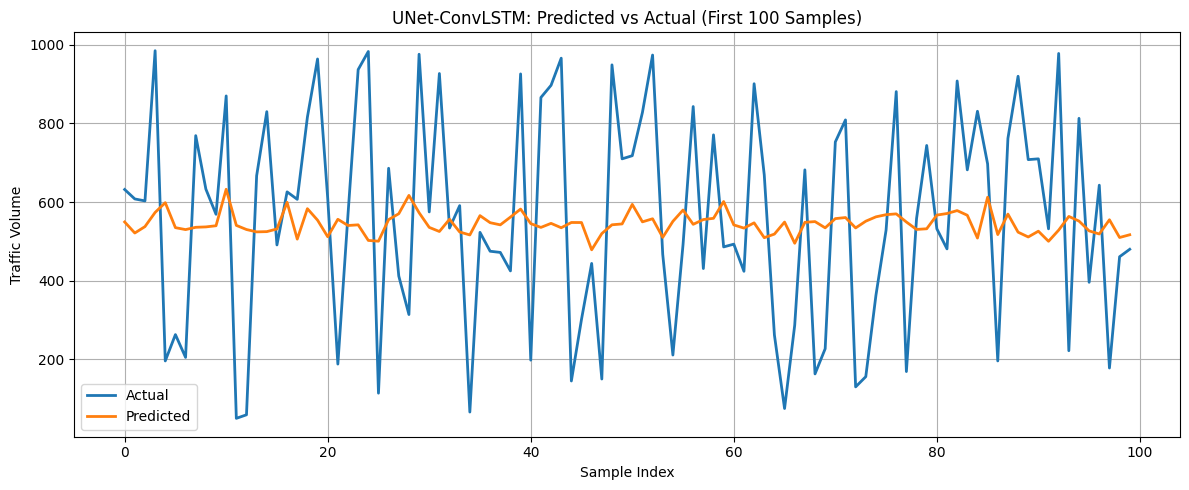


Last 20 Traffic Volume Predictions vs Actual:
 368) Actual: 682.00, Predicted: 538.02
 369) Actual: 50.00, Predicted: 561.97
 370) Actual: 725.00, Predicted: 564.29
 371) Actual: 811.00, Predicted: 529.86
 372) Actual: 57.00, Predicted: 578.16
 373) Actual: 68.00, Predicted: 554.81
 374) Actual: 603.00, Predicted: 530.63
 375) Actual: 610.00, Predicted: 567.36
 376) Actual: 941.00, Predicted: 578.24
 377) Actual: 701.00, Predicted: 602.65
 378) Actual: 81.00, Predicted: 562.80
 379) Actual: 270.00, Predicted: 588.59
 380) Actual: 780.00, Predicted: 551.82
 381) Actual: 978.00, Predicted: 562.21
 382) Actual: 307.00, Predicted: 536.10
 383) Actual: 317.00, Predicted: 524.02
 384) Actual: 582.00, Predicted: 580.57
 385) Actual: 514.00, Predicted: 580.35
 386) Actual: 851.00, Predicted: 519.68
 387) Actual: 161.00, Predicted: 524.55


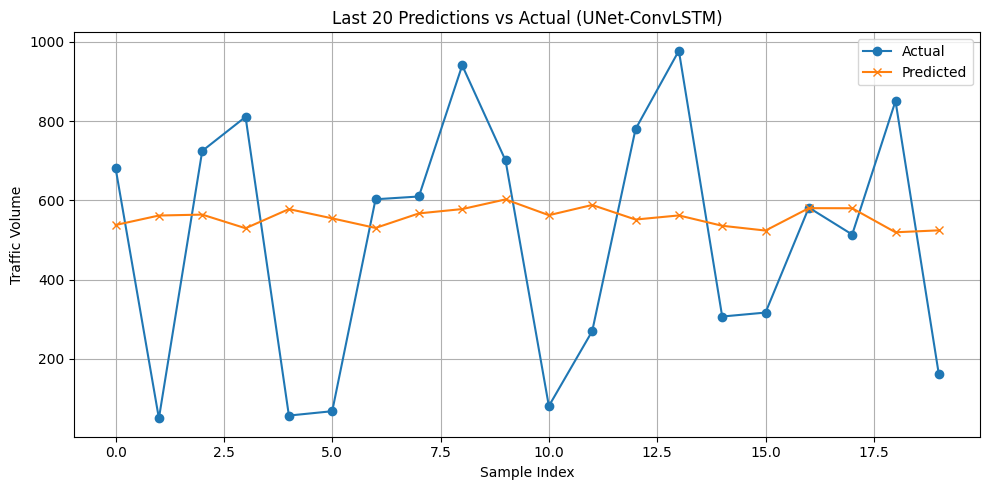

In [7]:
# --- Plot prediction vs actual (first 100) ---
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:100], label='Actual', linewidth=2)
plt.plot(y_pred_inv[:100], label='Predicted', linewidth=2)
plt.title("UNet-ConvLSTM: Predicted vs Actual (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Traffic Volume")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Print last 20 predictions ---
print("\nLast 20 Traffic Volume Predictions vs Actual:")
for i in range(-20, 0):
    actual = y_test_inv[i][0]
    predicted = y_pred_inv[i][0]
    print(f"{len(y_test_inv) + i + 1:4d}) Actual: {actual:.2f}, Predicted: {predicted:.2f}")

# --- Plot last 20 predictions ---
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[-20:], label='Actual', marker='o')
plt.plot(y_pred_inv[-20:], label='Predicted', marker='x')
plt.title("Last 20 Predictions vs Actual (UNet-ConvLSTM)")
plt.xlabel("Sample Index")
plt.ylabel("Traffic Volume")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()